In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

try:
    IterativeRefinementNet
except NameError:
    class IterativeRefinementNet(nn.Module):
        def __init__(self, input_size, hidden_sizes, num_iterations, output_size, activation_str):
            super().__init__()
            act = {"relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation_str]
            layers = []
            last = input_size
            for h in hidden_sizes:
                layers += [nn.Linear(last, h), act]
                last = h
            layers.append(nn.Linear(last, output_size))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x.view(x.size(0), -1))

try:
    StandardFeedForwardNet
except NameError:
    class StandardFeedForwardNet(nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size, activation_str):
            super().__init__()
            act = {"relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation_str]
            layers = []
            last = input_size
            for h in hidden_sizes:
                layers += [nn.Linear(last, h), act]
                last = h
            layers.append(nn.Linear(last, output_size))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x.view(x.size(0), -1))

try:
    get_monk1_data
except NameError:
    def get_monk1_data(batch_size, data_root="./data"):
        raise NotImplementedError("Provide your get_monk1_data(batch_size, data_root) implementation.")

try:
    get_ml_cup_data
except NameError:
    def get_ml_cup_data(batch_size):
        raise NotImplementedError("Provide your get_ml_cup_data(batch_size) implementation.")


In [ ]:
import json

## configuration presets
config_presets = {
    "monk1_standard": {
        "model": "standard",
        "dataset": "monk1",
        "activation": "tanh",
        "hidden_sizes": [3],
        "epochs": 1000,
        "batch_size": 64,
        "lr": 0.001
    },

    "mlcup_standard": {
        "model": "standard",
        "dataset": "mlc25",
        "activation": "tanh",
        "hidden_sizes": [50, 20],
        "epochs": 150,
        "batch_size": 64,
        "lr": 0.001
    },

    "mnist_standard": {
        "model": "standard",
        "dataset": "mnist",
        "activation": "sigmoid",
        "hidden_sizes": [256, 128, 64],
        "epochs": 10,
        "batch_size": 64,
        "lr": 0.001
    },

    "mnist_stepout": {
        "model": "step_out",
        "dataset": "mnist",
        "activation": "sigmoid",
        "hidden_sizes": [256, 128, 64],
        "epochs": 10,
        "batch_size": 64,
        "lr": 0.001
    }
}

cfg = config_presets["mnist_standard"]

NUM_ITERATIONS = len(cfg["hidden_sizes"])
LEARNING_RATE = cfg["lr"]
BATCH_SIZE = cfg["batch_size"]
NUM_EPOCHS = cfg["epochs"]
ACTIVATION = cfg["activation"]

data_root = "./data"
is_regression_task = False

print("Config:", json.dumps(cfg, indent=2))

Config: {
  "model": "standard",
  "dataset": "mnist",
  "activation": "sigmoid",
  "hidden_sizes": [
    256,
    128,
    64
  ],
  "epochs": 10,
  "batch_size": 64,
  "lr": 0.001
}


In [ ]:
# Dataset loading + task type

train_loader = None
test_loader = None
INPUT_SIZE = None
OUTPUT_SIZE = None
metric_name = "Test Accuracy"

print(f"Loading dataset: {cfg['dataset'].upper()}")

if cfg["dataset"] == "monk1":
    train_loader, test_loader, INPUT_SIZE, OUTPUT_SIZE = get_monk1_data(BATCH_SIZE, data_root)
    metric_name = "Test monk"

elif cfg["dataset"] == "mlc25":
    train_loader, test_loader, INPUT_SIZE, OUTPUT_SIZE = get_ml_cup_data(BATCH_SIZE)
    is_regression_task = True
    metric_name = "Test MSE"

else:
    if cfg["dataset"] == "mnist":
        normalize_mean, normalize_std = (0.1307,), (0.3081,)
        dataset_class = torchvision.datasets.MNIST
    elif cfg["dataset"] == "fmnist":
        normalize_mean, normalize_std = (0.2860,), (0.3530,)
        dataset_class = torchvision.datasets.FashionMNIST
    elif cfg["dataset"] == "kmnist":
        normalize_mean, normalize_std = (0.1918,), (0.3483,)
        dataset_class = torchvision.datasets.KMNIST
    else:
        raise ValueError(f"Unknown dataset: {cfg['dataset']}")

    INPUT_SIZE = 28 * 28
    OUTPUT_SIZE = 10

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ])

    train_dataset = dataset_class(root=data_root, train=True, transform=transform, download=True)
    test_dataset  = dataset_class(root=data_root, train=False, transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Detected Input Size: {INPUT_SIZE}, Output Size: {OUTPUT_SIZE}")


Loading dataset: MNIST
Detected Input Size: 784, Output Size: 10


In [13]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using device: Apple MPS (M1/M2 GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device: NVIDIA CUDA")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

print(f"Using Model: {cfg['model'].upper()}")
print(f"Using Activation: {ACTIVATION.upper()}")

if cfg["model"] == "step_out":
    model = IterativeRefinementNet(
        input_size=INPUT_SIZE,
        hidden_sizes=cfg["hidden_sizes"],
        num_iterations=NUM_ITERATIONS,
        output_size=OUTPUT_SIZE,
        activation_str=ACTIVATION
    ).to(device)
elif cfg["model"] == "standard":
    model = StandardFeedForwardNet(
        input_size=INPUT_SIZE,
        hidden_sizes=cfg["hidden_sizes"],
        output_size=OUTPUT_SIZE,
        activation_str=ACTIVATION
    ).to(device)
else:
    raise ValueError(f"Unknown PyTorch model_type: {cfg['model']}")

print("Model architecture:")
print(model)


Using device: Apple MPS (M1/M2 GPU)
Using Model: STANDARD
Using Activation: SIGMOID
Model architecture:
StandardFeedForwardNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
# Criterion, optimizer, trackers

criterion = nn.MSELoss() if is_regression_task else nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

epoch_train_losses = []
epoch_test_metrics = []

print(f"Training for {NUM_EPOCHS} epochs...")

Training for 10 epochs...


In [ ]:
# Training loop with evaluation each epoch

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        log_frequency = max(1, len(train_loader) // 4)
        if (i + 1) % log_frequency == 0 or (i + 1) == len(train_loader):
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    epoch_train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] complete. Average Training Loss: {avg_train_loss:.4f}")

    # --- Evaluation ---
    model.eval()
    running_metric = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)

            if is_regression_task:
                loss = criterion(outputs, labels)
                running_metric += loss.item()
            else:
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    if is_regression_task:
        metric = running_metric / len(test_loader)  # Average Test MSE
        epoch_test_metrics.append(metric)
        print(f"Average Test MSE (lower is better) after epoch {epoch+1}: {metric:.4f}")
    else:
        metric = 100.0 * correct / total  # Test Accuracy
        epoch_test_metrics.append(metric)
        print(f"Accuracy of the network after epoch {epoch+1}: {metric:.2f} %")

print("Finished Training!")


Epoch [1/10], Step [234/938], Loss: 0.6481
Epoch [1/10], Step [468/938], Loss: 0.3800
Epoch [1/10], Step [702/938], Loss: 0.3322
Epoch [1/10], Step [936/938], Loss: 0.2076
Epoch [1/10], Step [938/938], Loss: 0.3183
Epoch [1/10] complete. Average Training Loss: 0.6274
Accuracy of the network after epoch 1: 94.85 %
Epoch [2/10], Step [234/938], Loss: 0.2616
Epoch [2/10], Step [468/938], Loss: 0.0934
Epoch [2/10], Step [702/938], Loss: 0.1898
Epoch [2/10], Step [936/938], Loss: 0.1678
Epoch [2/10], Step [938/938], Loss: 0.0391
Epoch [2/10] complete. Average Training Loss: 0.1512
Accuracy of the network after epoch 2: 96.65 %
Epoch [3/10], Step [234/938], Loss: 0.0397
Epoch [3/10], Step [468/938], Loss: 0.0455
Epoch [3/10], Step [702/938], Loss: 0.3025
Epoch [3/10], Step [936/938], Loss: 0.0981
Epoch [3/10], Step [938/938], Loss: 0.1259
Epoch [3/10] complete. Average Training Loss: 0.0941
Accuracy of the network after epoch 3: 96.74 %
Epoch [4/10], Step [234/938], Loss: 0.0197
Epoch [4/10]

Generating plot...


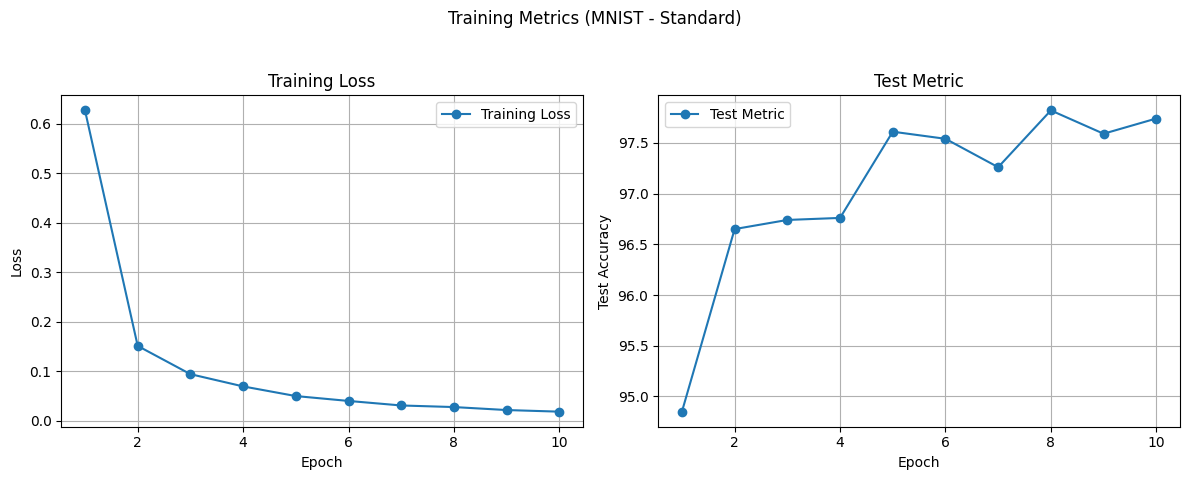

In [ ]:
# Plot results

print("Generating plot...")
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, epoch_train_losses, 'o-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, epoch_test_metrics, 'o-', label='Test Metric')
plt.title('Test Metric')
plt.xlabel('Epoch')
plt.ylabel(metric_name)
plt.legend()
plt.grid(True)

plt.suptitle(f"Training Metrics ({cfg['dataset'].upper()} - {cfg['model'].title()})")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()